# Demo v2 

In [1]:
#Set up environment
import os
import scipy.signal
import math
import json
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Add Pulsar QRM interface
from pulsar_qrm.pulsar_qrm import pulsar_qrm
from pulsar_qcm.pulsar_qcm import pulsar_qcm

In [3]:
qcm = pulsar_qcm("qcm0", "192.168.0.3", debug=1)
qcm.get_idn()

{'manufacturer': 'Qblox',
 'device': 'Pulsar QCM',
 'serial_number': '',
 'build': {'firmware': {'version': '0.1.0',
   'date': '04/08/2020-07:03:35',
   'hash': '0xD12A1BA',
   'dirty': False},
  'kernel_mod': {'version': '0.1.0',
   'date': '04/08/2020-12:27:50',
   'hash': '0x1128E33B',
   'dirty': True},
  'software': {'version': '0.1.0',
   'date': '04/08/2020-12:27:50',
   'hash': '0x1128E33B',
   'dirty': True}}}

In [4]:
#Connect to device over ethernet
qrm = pulsar_qrm("qrm0", "192.168.0.2", debug=1)
qrm.get_idn()

{'manufacturer': 'Qblox',
 'device': 'Pulsar QRM',
 'serial_number': '',
 'build': {'firmware': {'version': '0.1.0',
   'date': '06/08/2020-13:19:30',
   'hash': '0x3EF6A1FE',
   'dirty': True},
  'kernel_mod': {'version': '0.1.0',
   'date': '06/08/2020-13:19:30',
   'hash': '0x3EF6A1FE',
   'dirty': True},
  'software': {'version': '0.1.0',
   'date': '06/08/2020-13:19:30',
   'hash': '0x3EF6A1FE',
   'dirty': True}}}

In [5]:
qrm.stop_sequencer()
qcm.stop_sequencer()

In [6]:
#Get system status
print(qrm.get_system_status())
print("FPGA temp;    curr: {}, max: {}".format(qrm.get_current_fpga_temperature(),    qrm.get_maximum_fpga_temperature()))
print("Carrier temp; curr: {}, max: {}".format(qrm.get_current_carrier_temperature(), qrm.get_maximum_carrier_temperature()))
print("AFE temp;     curr: {}, max: {}".format(qrm.get_current_afe_temperature(),     qrm.get_maximum_afe_temperature()))

{'status': 'OKAY', 'flags': []}
FPGA temp;    curr: 50, max: 52
Carrier temp; curr: 37, max: 37
AFE temp;     curr: 42, max: 42


In [7]:
from quantify.sequencer.types import Schedule, Operation
from quantify.sequencer.gate_library import Reset, Measure, CNOT, CZ, Rxy, X90, X
from quantify.sequencer.pulse_library import IdlePulse
from quantify.sequencer.backends.pulsar_backend import pulsar_assembler_backend, configure_pulsar_sequencers
from quantify.sequencer.backends.visualization import pulse_diagram_plotly
from quantify.sequencer.resources import QubitResource, CompositeResource, Pulsar_QCM_sequencer, Pulsar_QRM_sequencer
from quantify.sequencer.compilation import add_pulse_information_transmon, determine_absolute_timing

In [8]:
DEVICE_TEST_CFG = {
    "qubits":
    {
        "q0": {"mw_amp180": 0.3, "mw_motzoi": -0.25, "mw_duration": 30e-9,
               "mw_modulation_freq": 50e6, "mw_ef_amp180": 0.87, "mw_ch": "qcm0.s0",
               "ro_ch": "qrm0.s0", "ro_pulse_amp": 0.5, "ro_pulse_modulation_freq": 0,
               "ro_pulse_type": "square", "ro_pulse_duration": 150e-9,
               "ro_acq_delay": 0, "ro_acq_integration_time": 2500e-9,
               "ro_acq_weigth_type": "SSB",
               "init_duration": 250e-6
               }
    },
    "edges": {}
}

In [9]:
sched = Schedule('sched')
q0 = QubitResource('q0')

"""
x = X(q0.name)
sched.add(x, rel_time=150e-9, ref_op='measure', ref_pt='start')
for i in [2, 4, 8, 16]:
    sched.add(x, rel_time=4e-9 * i)
"""

# this is what the unrolled T1 will look like, but we need a fake qubit on an arduino or something
# setpoints = the relaxation range
# settable prepares the Qubit (randomising its relaxation)
# settable creates the Sequence and configures pulsars
# gettable prepare arms and starts the sequencers
# gettable reads back the acquisitions
# response should go from high to low at some point, just need to find that

# make fake Qubit with QCodes

sched.add(Measure(q0.name), label='measurement')
sched.add(X(q0.name), rel_time=200e-9)
for t in np.linspace(20e-9, 100e-9, 4):
    sched.add(X(q0.name), rel_time=t)


qcm0_s0 = Pulsar_QCM_sequencer('qcm0.s0', instrument_name='qcm0', seq_idx=0)
qrm0_s0 = Pulsar_QRM_sequencer('qrm0.s0', instrument_name='qrm0', seq_idx=0)

sched.add_resources([q0, qrm0_s0, qcm0_s0])

sched = add_pulse_information_transmon(sched, DEVICE_TEST_CFG)
sched = determine_absolute_timing(sched)

seq_config_dict = pulsar_assembler_backend(sched)

In [10]:
configure_pulsar_sequencers(seq_config_dict)
qrm.set("sequencer0_trigger_mode_acq_path0", False)
qrm.set("sequencer0_trigger_mode_acq_path1", True)

In [11]:
"""
#Waveforms
waveform_len = 1000
waveforms    = {
    "block":    {"data": [], "index": 0},
}

acqs = {
    "empty":    {"data": list(np.zeros(waveform_len)), "index": 0}
}

#Create block waveform
if "block" in waveforms:
    waveforms["block"]["data"] = [1.0 for i in range(0, waveform_len)]

#Sequence programs
seq_prog = []
for seq in range(0, 2):
    with open("demo_seq{}.q1asm".format(seq), 'r') as file:
        seq_prog.append(file.read())

#QCM
for name in waveforms:
    if str(type(waveforms[name]["data"]).__name__) == "ndarray":
        waveforms[name]["data"] = waveforms[name]["data"].tolist()

for seq, prog in enumerate(seq_prog):
    wave_and_prog_dict = {"waveforms": {"awg": waveforms},
                          "program": prog}
    with open("demo_seq{}.json".format(seq), 'w', encoding='utf-8') as file:
        json.dump(wave_and_prog_dict, file, indent=4)
        file.close()

#QRM
with open("demo_qrm_seq{}.q1asm".format(0), 'r') as file:
    seq_prog = file.read()
for name in waveforms:
    if str(type(waveforms[name]["data"]).__name__) == "ndarray":
        waveforms[name]["data"] = waveforms[name]["data"].tolist()

wave_and_prog_dict = {"waveforms": {"awg": waveforms,
                                    "acq": acqs},
                      "program": seq_prog}

with open("demo_qrm_seq0.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()
    
#Upload waveforms and programs
for seq in range(0, 2):
    qcm.set("sequencer{}_waveforms_and_program".format(seq), os.path.join(os.getcwd(), "demo_seq{}.json".format(seq)))
    print(qcm.get_assembler_log())
    
qrm.set("sequencer{}_waveforms_and_program".format(0), os.path.join(os.getcwd(), "demo_qrm_seq0.json"))
print(qrm.get_assembler_log())

#Configure the sequencers
for seq in range(0, 2):
    qcm.set("sequencer{}_sync_en".format(seq),                          True)
    qcm.set("sequencer{}_cont_mode_en_awg_path0".format(seq),           False)
    qcm.set("sequencer{}_cont_mode_en_awg_path1".format(seq),           False)
    qcm.set("sequencer{}_cont_mode_waveform_idx_awg_path0".format(seq), 0)
    qcm.set("sequencer{}_cont_mode_waveform_idx_awg_path1".format(seq), 0)
    qcm.set("sequencer{}_upsample_rate_awg_path0".format(seq),          0)
    qcm.set("sequencer{}_upsample_rate_awg_path1".format(seq),          0)
    qcm.set("sequencer{}_gain_awg_path0".format(seq),                   1.0)
    qcm.set("sequencer{}_gain_awg_path1".format(seq),                   1.0)
    qcm.set("sequencer{}_offset_awg_path0".format(seq),                 0)
    qcm.set("sequencer{}_offset_awg_path1".format(seq),                 0)
    qcm.set("sequencer{}_mod_en_awg".format(seq),                       True)
    qcm.set("sequencer{}_nco_freq".format(seq),                         10e6)
    qcm.set("sequencer{}_nco_phase".format(seq),                        0)
    
seq = 0
qrm.set("sequencer{}_sync_en".format(seq),                          True)
qrm.set("sequencer{}_cont_mode_en_awg_path0".format(seq),           False)
qrm.set("sequencer{}_cont_mode_en_awg_path1".format(seq),           False)
qrm.set("sequencer{}_cont_mode_waveform_idx_awg_path0".format(seq), 0)
qrm.set("sequencer{}_cont_mode_waveform_idx_awg_path1".format(seq), 0)
qrm.set("sequencer{}_upsample_rate_awg_path0".format(seq),          0)
qrm.set("sequencer{}_upsample_rate_awg_path1".format(seq),          0)
qrm.set("sequencer{}_gain_awg_path0".format(seq),                   1.0)
qrm.set("sequencer{}_gain_awg_path1".format(seq),                   1.0)
qrm.set("sequencer{}_offset_awg_path0".format(seq),                 0)
qrm.set("sequencer{}_offset_awg_path1".format(seq),                 0)
qrm.set("sequencer{}_mod_en_awg".format(seq),                       True)
qrm.set("sequencer{}_nco_freq".format(seq),                         10e6)
qrm.set("sequencer{}_nco_phase".format(seq),                        0)
qrm.set("sequencer{}_trigger_mode_acq_path0".format(seq),           False)
qrm.set("sequencer{}_trigger_mode_acq_path1".format(seq),           False)
"""

'\n#Waveforms\nwaveform_len = 1000\nwaveforms    = {\n    "block":    {"data": [], "index": 0},\n}\n\nacqs = {\n    "empty":    {"data": list(np.zeros(waveform_len)), "index": 0}\n}\n\n#Create block waveform\nif "block" in waveforms:\n    waveforms["block"]["data"] = [1.0 for i in range(0, waveform_len)]\n\n#Sequence programs\nseq_prog = []\nfor seq in range(0, 2):\n    with open("demo_seq{}.q1asm".format(seq), \'r\') as file:\n        seq_prog.append(file.read())\n\n#QCM\nfor name in waveforms:\n    if str(type(waveforms[name]["data"]).__name__) == "ndarray":\n        waveforms[name]["data"] = waveforms[name]["data"].tolist()\n\nfor seq, prog in enumerate(seq_prog):\n    wave_and_prog_dict = {"waveforms": {"awg": waveforms},\n                          "program": prog}\n    with open("demo_seq{}.json".format(seq), \'w\', encoding=\'utf-8\') as file:\n        json.dump(wave_and_prog_dict, file, indent=4)\n        file.close()\n\n#QRM\nwith open("demo_qrm_seq{}.q1asm".format(0), \'r\') a

In [12]:
#Start the sequencers
qrm.arm_sequencer()
qcm.arm_sequencer()

qrm.start_sequencer()
qcm.start_sequencer()

In [13]:
time.sleep(1.0)

In [14]:
#Stop the sequencers
qcm.stop_sequencer()
qrm.stop_sequencer()

In [15]:
#Get acquisition
seq = 0
qrm.delete_acquisitions(seq)
qrm.store_acquisition(seq, "meas_0", 450)
acq = qrm.get_acquisitions(seq)

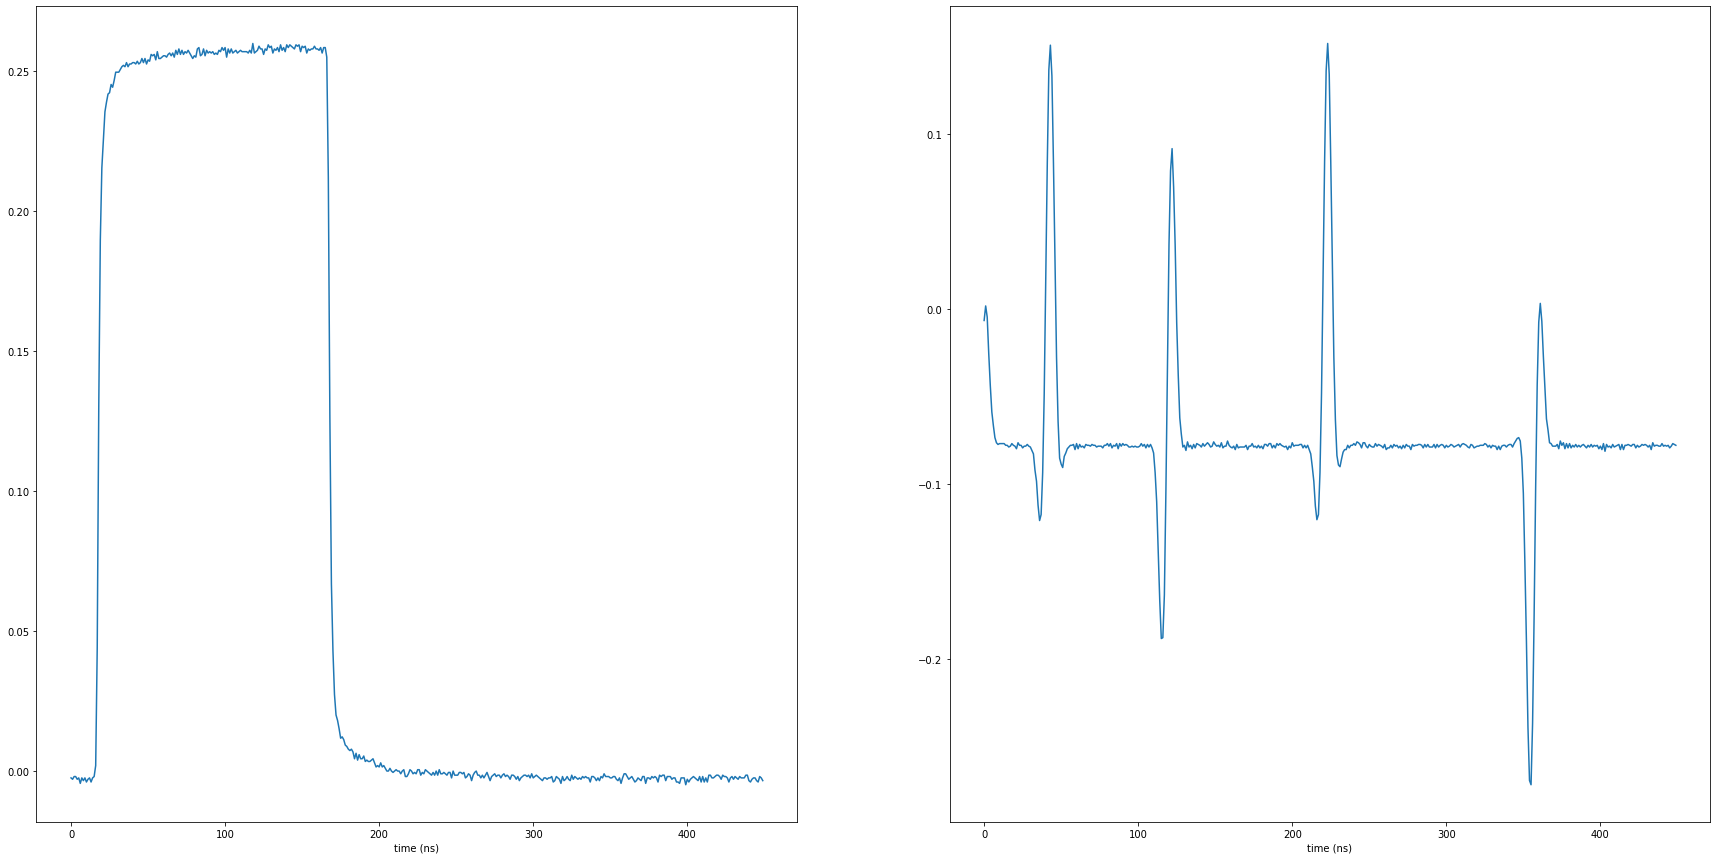

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(30,15))
ax[0].plot(acq["meas_0"]["path_0"]["data"])
ax[0].set_xlabel('time (ns)')
ax[1].plot(acq["meas_0"]["path_1"]["data"])
ax[1].set_xlabel('time (ns)')
plt.show()